# Model Benchmarking Pipeline

We'll work on a dataset of Git issues and PR, with multi-label.
The goal is to build a pipeline to evaluate different model performance. Using no data, few labeled data or unlabeled data.

### Exploring the data

In [13]:
import pandas as pd

dataset_url = 'https://git.io/nlp-with-transformers'
df_issues = pd.read_json(dataset_url, lines=True)

print(f"dataframe shape: {df_issues.shape}")

dataframe shape: (9930, 26)


In [14]:
# Sample of an issue:
cols = ['url', 'id', 'title', 'user', 'labels', 'state', 'created_at', 'body']
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


We just need the 'name' of the labels not the full json.

In [15]:
df_issues['labels'] = (df_issues['labels'].apply( lambda x: [meta['name'] for meta in x]))
df_issues[['labels']].head(10)

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]
5,[]
6,[]
7,[]
8,[]
9,[]


In [16]:
# Number of labels per issue
df_issues['labels'].apply(lambda x: len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [17]:
df_counts = df_issues['labels'].explode().value_counts()
print(f'Number of labels: {len(df_counts)}')
#Display the top 8 labels categories
df_counts.to_frame().head(8).T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


Let's define the labels that we want to work with here:

In [18]:
label_map = {
    'Core: Tokenization': 'tokenization',
    'New model': 'new model',
    'Core: Modeling': 'model training',
    'Usage': 'usage',
    'Core: Pipeline': 'pipeline',
    'TensorFlow': 'tensorflow',
    'Pytorch': 'pytorch',
    'Examples': 'examples',
    'Documentation': 'documentation'
}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues['labels'] = df_issues['labels'].apply(filter_labels)

all_labels = list(label_map.values())

df_counts = df_issues['labels'].explode().value_counts()
df_counts.to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow,documentation,examples
count,106,98,64,46,42,41,28,24


Let's find out how many unlabelled issues

In [19]:
df_issues['split'] = 'unlabeled'
mask = df_issues['labels'].apply(lambda x: len(x)) > 0
df_issues.loc[mask, 'split'] = 'labeled'
df_issues['split'].value_counts().to_frame()

,count
split,
unlabeled,9511
labeled,419


In [20]:
# merge 'title' and 'body' into one text feature.
df_issues['text'] = (df_issues.apply(lambda x: x['title'] + '\n\n' + x['body'], axis=1))

In [21]:
# drop text duplicates
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset='text')
print(f'Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.')

Removed 1.88% duplicates.


Let's have a look at the length distribution of the text

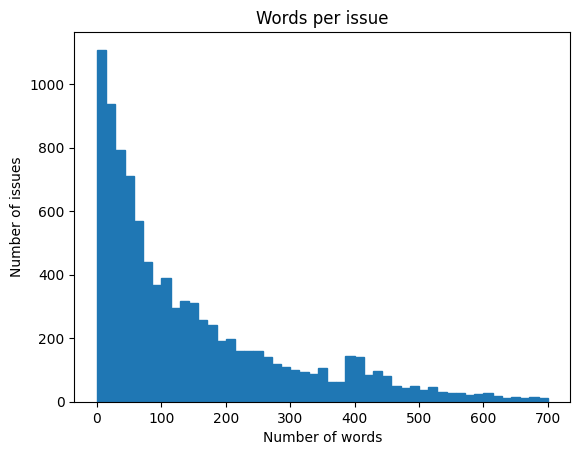

In [23]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues['text'].str.split().apply(len).hist(bins=np.linspace(0,700,50), grid=False, edgecolor='C0'))
plt.title('Words per issue')
plt.xlabel('Number of words')
plt.ylabel('Number of issues')
plt.show()



Most of the text are under 500 words, so we can use models like BERT with a max input sequence length of 512

### Creating Training Sets and training splits

In [25]:
print(all_labels)

['tokenization', 'new model', 'model training', 'usage', 'pipeline', 'tensorflow', 'pytorch', 'examples', 'documentation']


In [26]:
# use a multi label approach with Sklearn

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])

#test
mlb.transform([['tokenization', 'new model'], ['pytorch']])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [156]:
mlb.transform([['tokenization'], ['pytorch'], ['new model'], ['model training'], ['usage'], ['pipeline'], ['examples'], ['documentation'], ['tensorflow']])

array([[0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0]])

In order to get balanced labels for our datasets, we use sklearn's iterative_train_test_split

In [28]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    idx = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df['labels'])
    idx_train, _, idx_test, _ = iterative_train_test_split(idx, labels, test_size)
    return df.iloc[idx_train[:,0]], df.iloc[idx_test[:,0]]


Now let's split the data into supervised train, validation and test set, and unsupervised set.

In [29]:
df_clean = df_issues[['text', 'labels', 'split']].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean['split'] == 'unlabeled', ['text', 'labels']]
df_sup = df_clean.loc[df_clean['split'] == 'labeled', ['text', 'labels']]

np.random.seed(42)
df_train, df_tmp = balanced_split(df_sup)
df_valid, df_test = balanced_split(df_tmp)

In [32]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    'train': Dataset.from_pandas(df_train.reset_index(drop=True)),
    'valid': Dataset.from_pandas(df_valid.reset_index(drop=True)),
    'test': Dataset.from_pandas(df_test.reset_index(drop=True)),
    'unsup': Dataset.from_pandas(df_unsup.reset_index(drop=True)),
})

/Users/clement/anaconda3/envs/gpu/lib/python3.9/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


#### Create Training Slices

We'll evaluate the models performances as a function of the number of training samples

In [34]:
np.random.seed(42)
all_indices = np.expand_dims(list(range(len(ds['train']))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds['train']['labels'])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i,k in enumerate(train_samples):
    # split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i == 0:
        train_slices.append(new_slice)
    else:
        train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# add full dataset as last slice
train_slices.append(all_indices)
train_samples.append(len(ds['train']))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

print(f'Target split sizes: {train_samples}')
print(f'Actual split sized: {[len(x) for x in train_slices]}')

Target split sizes: [8, 16, 32, 64, 128, 212]
Actual split sized: [9, 18, 36, 67, 132, 212]


### Implement Naive Bayes classifier as a baseline

In [36]:
def prepare_labels(batch):
    batch['label_ids'] = mlb.transform(batch['labels'])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/9325 [00:00<?, ? examples/s]

In [39]:
ds['train']['label_ids'][0:5]

[[0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0]]

Prepare the metrics: F1 score micro and macro

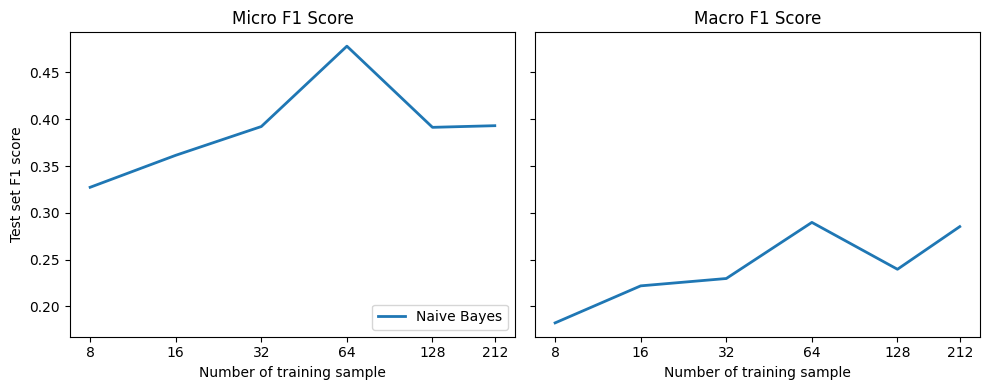

In [42]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

# Naive Bayes model

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # get training slice and test data
    ds_train_sample = ds['train'].select(train_slice)
    y_train = np.array(ds_train_sample['label_ids'])
    y_test = np.array(ds['test']['label_ids'])
    # Use CountVectorizer to encode text
    count_vect = CountVectorizer()
    X_train = count_vect.fit_transform(ds_train_sample['text'])
    X_test = count_vect.transform(ds['test']['text'])
    # Create and train model
    # we train multiple Naive Bayes classifier to handle the multi-labels
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test)
    clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True)
    # Store metrics
    macro_scores['Naive Bayes'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Naive Bayes'].append(clf_report['micro avg']['f1-score'])

import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), sharey=True)
    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle='dashed')
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle='dashed')
    ax0.set_title('Micro F1 Score')
    ax1.set_title('Macro F1 Score')
    ax0.set_ylabel('Test set F1 score')
    ax0.legend(loc='lower right')
    for ax in [ax0, ax1]:
        ax.set_xlabel('Number of training sample')
        ax.set_xscale('log')
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()


plot_metrics(micro_scores, macro_scores, train_samples, 'Naive Bayes')



### Zero-Shot Classification

In [43]:
from transformers import pipeline

pipe = pipeline('zero-shot-classification', device='mps')

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [45]:
sample = ds['train'][10]
print(f"labels: {sample['labels']}")
output = pipe(sample['text'], all_labels, multi_label=True)
print('Predictions:')
for label, score in zip(output['labels'], output['scores']):
    print(f'{label}, {score:.2f}')

labels: ['tensorflow']
Predictions:
tensorflow, 0.56
examples, 0.53
pytorch, 0.52
new model, 0.46
usage, 0.27
pipeline, 0.20
tokenization, 0.10
model training, 0.08
documentation, 0.05


In [46]:
def zero_shot_pipeline(example):
    output = pipe(example['text'], all_labels, multi_label=True)
    example['predicted_labels'] = output['labels']
    example['scores'] = output['scores']
    return example

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

In [47]:
# Define a get_preds function that can select labels based on a min threshold or a top k
def get_preds(example, threshold=None, topk = None):
    preds = []
    if threshold:
        for label, score in zip(example['predicted_labels'], example['scores']):
            if score > threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example['predicted_labels'][i])
    else:
        raise ValueError('Set either threshold or topk')
    return {'pred_label_ids': list(np.squeeze(mlb.transform([preds])))}

# Define a function that return the classification report from a dataset with predicted labels
def get_clf_report(ds):
    y_true = np.array(ds['label_ids'])
    y_pred = np.array(ds['pred_label_ids'])
    return classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)

We decide to only select the top 1 label with zero shot classification.

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

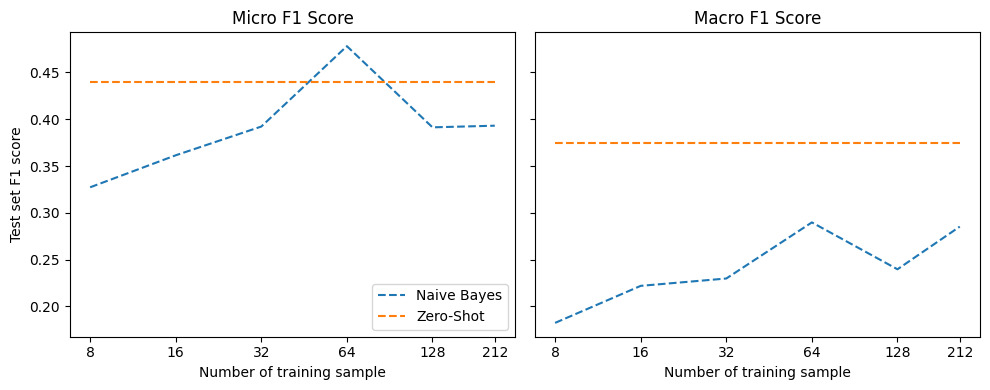

In [48]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores['Zero-Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero-Shot'].append(clf_report['micro avg']['f1-score'])



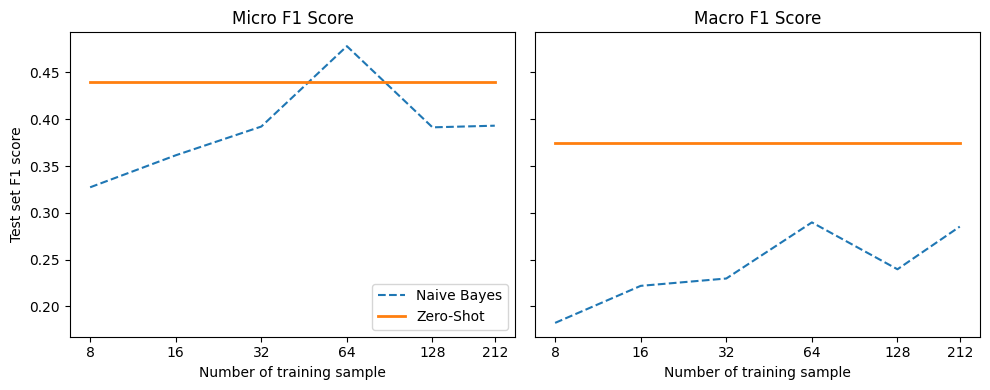

In [49]:
plot_metrics(micro_scores, macro_scores, train_samples, 'Zero-Shot')

### Fine-Tuning a Vanilla BERT Model (no domain adaptation)

In [50]:
import torch
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification)

model_id = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [51]:
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, max_length=500)

ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/9325 [00:00<?, ? examples/s]

In [52]:
# The multi-label loss function expects float for labels so we need to preprocess it
ds_enc.set_format('torch')
ds_enc = ds_enc.map(lambda x: {'label_ids_f': x['label_ids'].to(torch.float)}, remove_columns=['label_ids'])
ds_enc = ds_enc.rename_column('label_ids_f', 'label_ids')

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/9325 [00:00<?, ? examples/s]

In [53]:
ds_enc

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label_ids'],
        num_rows: 212
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label_ids'],
        num_rows: 104
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label_ids'],
        num_rows: 102
    })
    unsup: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'label_ids'],
        num_rows: 9325
    })
})

Now we can start training. Since we're likely to overfit on small traning slices, we set load_best_model_at_end=True

In [55]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    learning_rate=3e-5,
    lr_scheduler_type='constant',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=32,
    weight_decay=0.0,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='micro f1',
    save_total_limit=1,
    log_level='error'
)


Because the model return logits, we need to normalize the logits with a sigmoid function and apply a threshold to output a label vector of 0 and 1.

In [56]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)

    clf_dict = classification_report(y_true, y_pred, target_names=all_labels, zero_division=0, output_dict=True)
    return {'micro f1': clf_dict['micro avg']['f1-score'],
            'macro f1': clf_dict['macro avg']['f1-score']}

Now we're ready to train, on each training slices

In [ ]:
config = AutoConfig.from_pretrained(model_id)
config.num_labels = len(all_labels)
config.problem_type = 'multi_label_classification'

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_id, config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc['train'].select(train_slice),
        eval_dataset=ds_enc['valid'],
    )
    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    macro_scores['Fine-tune (vanilla)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (vanilla)'].append(metrics['micro f1'])



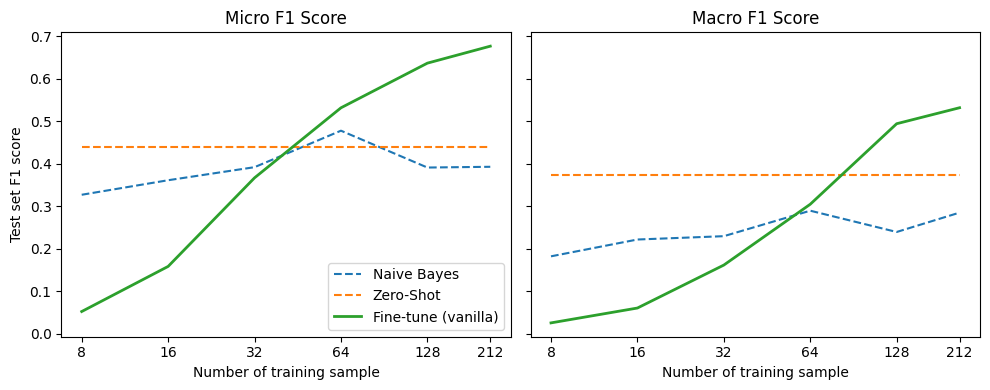

In [58]:
plot_metrics(micro_scores, macro_scores, train_samples, 'Fine-tune (vanilla)')

### Fine-tuning a BERT model with Domain Adaptation

We will use the unsupervised dataset, that is unlabeled, to pre-train the BERT model with Mask Language Modeling.

In order to do this, we need a special tokenizer that masks special tokens like [CLS] or [SEP]. 

And a Data Collator that will randomly mask a token in the input sentence, and the BERT model will have to predict what the masked token is durint the training phase.

In [71]:
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, max_length=300, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(['labels', 'text', 'label_ids'])

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/9325 [00:00<?, ? examples/s]

In [72]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15) # Same probability as in BERT paper
set_seed(42)
data_collator.return_tensors = 'np'

inputs = tokenizer("This is a longer sentence to say that I really enjoy working with transfomers and huggingface.", return_tensors='np')
outputs = data_collator([{'input_ids': inputs['input_ids'][0]}])

pd.DataFrame({
    'Original Tokens': tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]),
    'Masked Tokens': tokenizer.convert_ids_to_tokens(outputs['input_ids'][0]),
    'Original input_ids': inputs['input_ids'][0],
    'Masked input_ids': outputs['input_ids'][0],
    'Labels': outputs['labels'][0],
})

,Original Tokens,Masked Tokens,Original input_ids,Masked input_ids,Labels
0,[CLS],[CLS],101,101,-100
1,this,[MASK],2023,103,2023
2,is,is,2003,2003,-100
3,a,a,1037,1037,-100
4,longer,longer,2936,2936,-100
5,sentence,sentence,6251,6251,-100
6,to,to,2000,2000,-100
7,say,[MASK],2360,103,2360
8,that,that,2008,2008,-100
9,i,i,1045,1045,-100


In [73]:
# back to pytorch
data_collator.return_tensors = 'pt'

In [74]:
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir=f'{model_id}-git-issues-300',
    per_device_train_batch_size=32,
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    save_strategy='no',
    num_train_epochs=16,
    push_to_hub=True,
    log_level='error',
    report_to='none'
)

trainer = Trainer(
    model=AutoModelForMaskedLM.from_pretrained(model_id),
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds_mlm['unsup'],
    eval_dataset=ds_mlm['train']
)

trainer.train()



{'loss': 1.8844, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.5801472663879395, 'eval_runtime': 6.5519, 'eval_samples_per_second': 32.357, 'eval_steps_per_second': 4.121, 'epoch': 1.0}
{'loss': 1.4336, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.3510993719100952, 'eval_runtime': 3.5829, 'eval_samples_per_second': 59.169, 'eval_steps_per_second': 7.536, 'epoch': 2.0}
{'loss': 1.3005, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.3213118314743042, 'eval_runtime': 3.259, 'eval_samples_per_second': 65.051, 'eval_steps_per_second': 8.285, 'epoch': 3.0}
{'loss': 1.2259, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.313460111618042, 'eval_runtime': 2.5019, 'eval_samples_per_second': 84.736, 'eval_steps_per_second': 10.792, 'epoch': 4.0}
{'loss': 1.1555, 'learning_rate': 3.4375e-05, 'epoch': 5.0}
{'eval_loss': 1.211537480354309, 'eval_runtime': 3.2276, 'eval_samples_per_second': 65.684, 'eval_steps_per_second': 8.365

RepositoryNotFoundError: 401 Client Error. (Request ID: Root=1-668f5e4f-19496e066f53e938765d82ee;c824f456-e3b4-42bb-b3ef-a85a2dad92fb)

Repository Not Found for url: https://huggingface.co/api/models/KlemPear/bert-base-uncased-git-issues-300/preupload/main.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.
Invalid username or password.
Note: Creating a commit assumes that the repo already exists on the Huggingface Hub. Please use `create_repo` if it's not the case.

In [78]:

trainer.push_to_hub('Git issues BERT domain adaptation complete!')

training_args.bin:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

'https://huggingface.co/KlemPear/bert-base-uncased-git-issues-300/tree/main/'

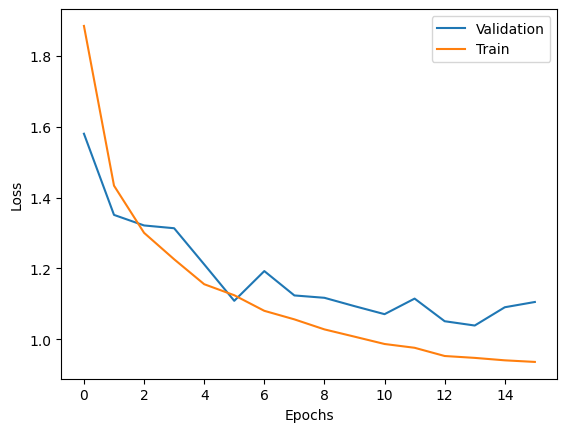

In [75]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=['eval_loss']).reset_index()['eval_loss'].plot(label='Validation'))
(df_log.dropna(subset=['loss']).reset_index()['loss'].plot(label='Train'))

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

#### Training the classifier after domain adaptation

In [ ]:
model_clf = f'{model_id}-git-issues-300'
config = AutoConfig.from_pretrained(model_clf)
config.num_labels = len(all_labels)
config.problem_type = 'multi_label_classification'

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_clf, config=config)

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc['train'].select(train_slice),
        eval_dataset=ds_enc['valid'],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)

    macro_scores['Fine-Tune with DA'].append(metrics['macro f1'])
    micro_scores['Fine-Tune with DA'].append(metrics['micro f1'])

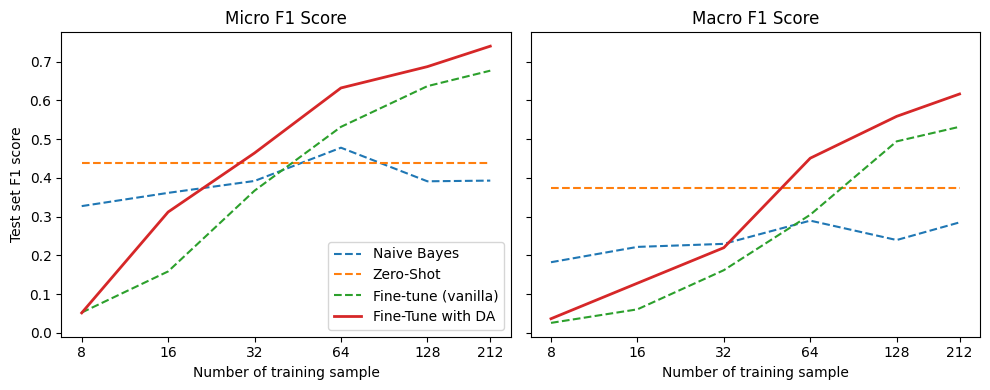

In [81]:
plot_metrics(micro_scores, macro_scores, train_samples, 'Fine-Tune with DA')

In [84]:
trainer.save_model('bert-base-uncased-git-issues-300-classifier')


In [ ]:
trainer.push_to_hub()

In [157]:
from transformers import pipeline

pipe = pipeline(model='KlemPear/bert-base-uncased-git-issues-300-classifier', device='mps')

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

In [173]:
i = 18
output = pipe(ds['test']['text'][i])
label = ds['test']['labels'][i]


In [174]:
output[0]['label']

'new model'

In [175]:
label[0]

'new model'